In [2]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

### define paths to data

In [3]:
## add helpers to python path
import sys
if '/home/jefan/neurosketch/python' not in sys.path:
    sys.path.append('/home/jefan/neurosketch/python')

## root paths    
curr_dir = os.getcwd()
data_dir = '../../data/'
proj_dir = '../../'
results_dir = '../../csv/'
nb_name = '2_object_evidence_during_drawing'

## module definitions
import analysis_helpers as h
reload(h)
h.data_dir = data_dir
h.path_to_recog = data_dir + 'features/recog'
h.path_to_draw = data_dir + 'features/drawing'
h.roi_list_draw = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'InsulaDraw', 'postCentralDraw',
                            'preCentralDraw', 'ParietalDraw', 'FrontalDraw', 'smgDraw'])
h.roi_list_recog = np.array(['V1', 'V2', 'LOC', 'fusiform','parahippo','IT','ento','PRC','hipp','mOFC'])
roi_list_recog = h.roi_list_recog

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### get file list

In [4]:
## get raw file list for recognition runs
path_to_recog = h.path_to_recog

RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] != 'Draw')])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] != 'Draw')])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [5]:
## get raw file list for drawing runs
path_to_draw = h.path_to_draw

DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] == 'Draw')])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] == 'Draw')])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [6]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
print 'Number of subs: {}'.format(len(sub_list))

Number of subs: 31


In [7]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

### How well do we do at classifying the target when we train on recognition patterns only?

#### generate ALLDM supersubject matrix with classifier probabilities

In [8]:
from IPython.display import clear_output
reload(h)
logged = [True,False]
versions = ['2way','3way','4way']

really_run = 0
if really_run:
    for l in logged:
        clear_output(wait=True)
        if l==True:
            tag = 'logged'
        elif l==False:
            tag = 'raw'
        for version in versions:
            ALLDM, Acc = h.make_drawing_predictions(sub_list,roi_list_recog,version=version,logged=l)
            ALLDM.to_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)),index=False) ## train recog, test drawing run    
            
            

In [9]:
if 'Acc' in locals():
    Acc = np.array(Acc)
    x = pd.DataFrame(Acc.transpose())
    x.columns = roi_list_recog
    
    sns.set_context('talk')
    plt.figure(figsize=(8,6))
    sns.barplot(data=x,palette='husl',ci=95)
    chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5}
    plt.axhline(chance_dict[version],linestyle=':',color='k')
    plt.ylabel('accuracy')
    plt.title('test on drawing runs; train on recognition runs')
    # plt.ylim(0,0.35)    

### make summary timecourse plots

In [10]:
version = '4way'
tag = 'logged'
ALLDM = pd.read_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)))

In [23]:
reload(h)
# print h.plot_summary_timecourse.__doc__

<module 'analysis_helpers' from '/home/jefan/neurosketch/python/analysis_helpers.pyc'>

In [24]:
reload(h)
h.plot_summary_timecourse(ALLDM,
                        this_iv='trial_num',
                        roi_list=roi_list_recog,
                        render_cond=1,
                        version = version,
                        proj_dir=proj_dir)

Now plotting results for V1 ...
Now plotting results for V2 ...
Now plotting results for LOC ...
Now plotting results for fusiform ...
Now plotting results for parahippo ...
Now plotting results for IT ...
Now plotting results for ento ...
Now plotting results for PRC ...
Now plotting results for hipp ...
Now plotting results for mOFC ...


#### get subject-level index of contrast between objects during drawing


In [29]:
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
version = '4way'
tag = 'logged'
ALLDM = pd.read_csv('{}/csv/logistic_timeseries_drawing_neural_{}_{}.csv'.format(proj_dir,version,tag))
ALLDM = h.cleanup_df(ALLDM)

In [30]:
reload(h)
this_iv = 'trial_num' ## other options 'run_num','trial_num','time_point'
version = '4way'

d = h.get_log_odds(ALLDM,
               this_iv = this_iv,
               roi_list = roi_list_recog,
               version=version,
               logged=True,
               proj_dir=proj_dir)

roi
IT           1.006930
LOC          1.437330
PRC          0.999914
V1           2.533271
V2           3.097584
ento         1.020229
fusiform     1.198620
hipp         1.026323
mOFC         1.066648
parahippo    0.986918
Name: target-foil, dtype: float64


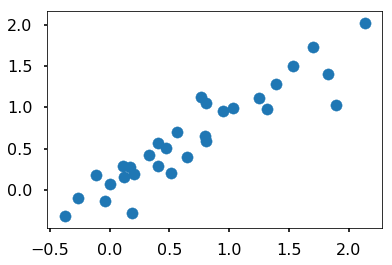

In [31]:
run_this = 1
if run_this:
    ## comparing 4-way and 2-way probability ratios
    d4way = pd.read_csv(proj_dir+'csv/difference_logprobs_4way.csv')
    d2way = pd.read_csv(proj_dir+'csv/difference_logprobs_2way.csv')
    inds = d4way['roi']=='V1'
    plt.scatter(d4way[inds]['target-foil'],d2way[inds]['target-foil'])

In [32]:
conditions = ['target-foil','target-control','foil-control']
for condition in conditions:
    print '------- condition: {} -------'.format(condition)
    for this_roi in roi_list_recog:
        data = d[d['roi']==this_roi][condition].values
        U,lb,ub,p = h.bootstrapCI(data,3000)
        print 'ROI = {} | mean = {}  95% CI: [{} {}] p={}'.format(this_roi,np.round(U,5),np.round(lb,3),np.round(ub,5),np.round(p,5))

------- condition: target-foil -------
ROI = V1 | mean = 0.69538  95% CI: [0.472 0.92676] p=0
ROI = V2 | mean = 0.79073  95% CI: [0.544 1.05589] p=0
ROI = LOC | mean = 0.32103  95% CI: [0.227 0.42033] p=0
ROI = fusiform | mean = 0.15829  95% CI: [0.081 0.23466] p=0
ROI = parahippo | mean = -0.02608  95% CI: [-0.081 0.0295] p=0
ROI = IT | mean = -0.01537  95% CI: [-0.088 0.05629] p=0
ROI = ento | mean = 0.00705  95% CI: [-0.052 0.06451] p=0
ROI = PRC | mean = -0.01341  95% CI: [-0.07 0.04382] p=0
ROI = hipp | mean = 0.01326  95% CI: [-0.042 0.07028] p=0
ROI = mOFC | mean = 0.0399  95% CI: [-0.037 0.11389] p=0
------- condition: target-control -------
ROI = V1 | mean = 0.247  95% CI: [0.113 0.38657] p=0
ROI = V2 | mean = 0.2912  95% CI: [0.148 0.43988] p=0
ROI = LOC | mean = 0.15865  95% CI: [0.066 0.26207] p=0
ROI = fusiform | mean = 0.09639  95% CI: [-0.034 0.22453] p=0
ROI = parahippo | mean = -0.0075  95% CI: [-0.069 0.05477] p=0
ROI = IT | mean = -0.08056  95% CI: [-0.168 0.00332] p

### How do individual differences in object evidence relate to individual differences in pre-post differentiation across ROIs?

In [ ]:
version = '4way'
tag = 'log'
d = pd.read_csv(os.path.join(proj_dir,'csv/difference_{}probs_{}.csv'.format(tag,version)))
prepost = pd.read_csv(os.path.join(proj_dir,'csv/neural_changes_by_surfroi_and_subject.csv'))

In [ ]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']

for this_roi in roi_list:
    draw = d[d['roi']==this_roi]['target-foil'].values
    recog = prepost['UnanchoredTrainedDiff_{}'.format(this_roi)].values-prepost['UnanchoredControlDiff_{}'.format(this_roi)].values

    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
    if np.round(p,5)<0.05:
        accent = '*'
    else:
        accent = ''
    print 'ROI: {}  r={}  p={} {}'.format(this_roi,np.round(r,5),np.round(p,5),accent)
    plt.xlabel('drawing: target vs. foil contrast') 
    plt.ylabel('recog: post-pre differentiation')
    if not os.path.exists(os.path.join(proj_dir,'plots{}/drawrecog'.format(nb_name))):
        os.makedirs(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name)))
    plt.tight_layout()
    plt.savefig(os.path.join(proj_dir,'plots/{}/drawrecog/draw_recog_scatter_{}.pdf'.format(nb_name,this_roi)))
    plt.close(fig)

### How are individual differences in object evidence related between ROIs? 

In [ ]:
### jgunn will add correlation matrices here